<a href="https://colab.research.google.com/github/fattahar/Finalterm-machine-learning/blob/main/Finalterm_regresi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install gdown

In [2]:
import gdown

gdown.download("https://drive.google.com/uc?id=1f8eaAZY-7YgFxLcrL3OkvSRa3onNNLb9")

Downloading...
From (original): https://drive.google.com/uc?id=1f8eaAZY-7YgFxLcrL3OkvSRa3onNNLb9
From (redirected): https://drive.google.com/uc?id=1f8eaAZY-7YgFxLcrL3OkvSRa3onNNLb9&confirm=t&uuid=dd365ba3-9f96-48ec-bb4a-13aeb2eb3059
To: /content/midterm-regresi-dataset.csv
100%|██████████| 443M/443M [00:10<00:00, 43.1MB/s]


'midterm-regresi-dataset.csv'

In [3]:
import pandas as pd


# Dataset ini tidak punya header.
# Nilai seperti 2001 di kolom pertama adalah TARGET (tahun), bukan nama feature /  kolom.
file_path = '/content/midterm-regresi-dataset.csv'
df = pd.read_csv(file_path)

df.head()

,2001,49.94357,21.47114,73.0775,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.0162,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
0,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
1,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
2,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
3,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903
4,2001,50.54767,0.31568,92.35066,22.38696,-25.51870,-19.04928,20.67345,-5.19943,3.63566,...,6.59753,-50.69577,26.02574,18.94430,-0.33730,6.09352,35.18381,5.00283,-11.02257,0.02263


In [4]:
print("df.shape:", df.shape) #ada 515344 row/baris dan 90 feature

df.shape: (515344, 91)


In [5]:
import os
file_size_bytes = os.path.getsize(file_path)
file_size_mb = file_size_bytes / (1024 ** 2)

print(f"Ukuran file: {file_size_bytes:,} bytes")
print(f"Ukuran file: {file_size_mb:.2f} MB")  #ukuran 422.88 MB, deadline 2 minggu. ngerjain mepet pasti ga kelar :))))

Ukuran file: 443,423,087 bytes
Ukuran file: 422.88 MB


# 1. SETUP & UTILITIES

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 2. DATA INGESTION & PREPARATION


Loading Dataset...
Missing Values: 0


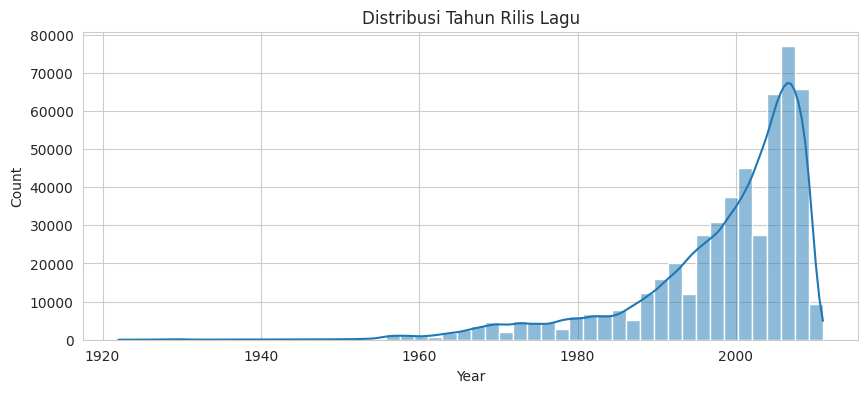

Train Shape: (412276, 90)
Test Shape: (103069, 90)


In [24]:
# A. Load Data
print("Loading Dataset...")
file_path = '/content/midterm-regresi-dataset.csv' # Sesuaikan jika perlu
df = pd.read_csv(file_path, header=None)

# B. Rename Columns
# Kolom 0 = Year, Kolom 1-90 = Timbre Features
df.columns = ['Year'] + [f'Feat_{i}' for i in range(1, 91)]

# C. Basic Cleaning
# Cek missing value (biasanya dataset ini bersih, tapi kita pastikan)
print(f"Missing Values: {df.isnull().sum().sum()}")
df = df.dropna()

# D. Feature Engineering Sederhana
# Fitur audio timbre 1-90 sudah engineered, kita tidak perlu ubah banyak.
# Tapi kita bisa cek distribusi target.
plt.figure(figsize=(10, 4))
sns.histplot(df['Year'], bins=50, kde=True)
plt.title("Distribusi Tahun Rilis Lagu")
plt.show()

# E. Split Data & Scaling
# Pisahkan Fitur (X) dan Target (y)
X = df.drop('Year', axis=1)
y = df['Year']

# Split: 80% Train, 20% Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standard Scaling (CRUCIAL untuk Deep Learning & Regresi)
# Fit hanya di Training set untuk mencegah data leakage
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train Shape: {X_train_scaled.shape}")
print(f"Test Shape: {X_test_scaled.shape}")

# 3. BENCHMARK MODEL: XGBOOST

In [28]:
import xgboost as xgb

print("🚀 Memulai Training XGBoost...")
print("Pantau 'validation_0-rmse' (Train) dan 'validation_1-rmse' (Test).")

# Konfigurasi Model (Parameter dipindah ke sini agar tidak error)
xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=7,
    tree_method='hist',
    n_jobs=-1,
    random_state=42,
    # PERBAIKAN PENTING DI SINI:
    eval_metric='rmse',
    early_stopping_rounds=50
)

# Training
xgb_reg.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
    verbose=50  # MENAMPILKAN LOG setiap 50 trees
)

# Prediksi
y_pred_xgb = xgb_reg.predict(X_test_scaled)
print("\n✅ Training XGBoost Selesai.")

🚀 Memulai Training XGBoost...
Pantau 'validation_0-rmse' (Train) dan 'validation_1-rmse' (Test).
[0]	validation_0-rmse:10.82869	validation_1-rmse:10.80444
[50]	validation_0-rmse:9.20344	validation_1-rmse:9.29689
[100]	validation_0-rmse:8.87369	validation_1-rmse:9.07065
[150]	validation_0-rmse:8.68285	validation_1-rmse:8.97204
[200]	validation_0-rmse:8.54251	validation_1-rmse:8.91664
[250]	validation_0-rmse:8.42416	validation_1-rmse:8.87845
[300]	validation_0-rmse:8.32697	validation_1-rmse:8.85299
[350]	validation_0-rmse:8.23989	validation_1-rmse:8.83091
[400]	validation_0-rmse:8.15959	validation_1-rmse:8.81254
[450]	validation_0-rmse:8.08561	validation_1-rmse:8.79775
[500]	validation_0-rmse:8.02093	validation_1-rmse:8.78699
[550]	validation_0-rmse:7.95178	validation_1-rmse:8.77519
[600]	validation_0-rmse:7.88997	validation_1-rmse:8.76527
[650]	validation_0-rmse:7.82885	validation_1-rmse:8.75749
[700]	validation_0-rmse:7.77200	validation_1-rmse:8.74954
[750]	validation_0-rmse:7.71024	va

# 4. CHALLENGER MODEL: DEEP NEURAL NETWORK

In [30]:
# 4. CHALLENGER MODEL: DEEP NEURAL NETWORK (REVISI)
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

print("🚀 Memulai Training Neural Network...")
print("Log proses (Epoch) akan muncul di bawah baris ini...\n")

# A. Arsitektur Model (Sama seperti sebelumnya)
model_dl = models.Sequential([
    layers.Input(shape=(90,)),

    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),

    layers.Dense(1, activation='linear')
])

# B. Compile
model_dl.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

# C. Training dengan Logging (Verbose=1)
# Callback untuk menampilkan learning rate jika berubah
lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)

history = model_dl.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=1024,
    verbose=1, # Menampilkan Progress Bar [==========]
    callbacks=[early_stopping, lr_scheduler]
)

# D. Predict & Evaluasi (Versi Aman / Anti-Error)
print("\n--- Evaluasi Model Deep Learning ---")
y_pred_dl = model_dl.predict(X_test_scaled).flatten()

# Hitung manual agar tidak kena error 'squared'
mse_val = mean_squared_error(y_test, y_pred_dl)
rmse_dl = np.sqrt(mse_val)  # Akar kuadrat dari MSE = RMSE
mae_val = mean_absolute_error(y_test, y_pred_dl)
r2_val = r2_score(y_test, y_pred_dl)

print(f"RMSE : {rmse_dl:.4f} (Rata-rata error tahun)")
print(f"MAE  : {mae_val:.4f}")
print(f"R²   : {r2_val:.4f}")

print("\n✅ Training & Evaluasi Neural Network Selesai.")

🚀 Memulai Training Neural Network...
Log proses (Epoch) akan muncul di bawah baris ini...

Epoch 1/30
323/323 ━━━━━━━━━━━━━━━━━━━━ 31s 83ms/step - loss: 3977420.7500 - rmse: 1994.3441 - val_loss: 3854475.0000 - val_rmse: 1963.2817 - learning_rate: 0.0010
Epoch 2/30
323/323 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - loss: 3774071.2500 - rmse: 1942.6523 - val_loss: 3469262.7500 - val_rmse: 1862.5957 - learning_rate: 0.0010
Epoch 3/30
323/323 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - loss: 3337366.5000 - rmse: 1826.7211 - val_loss: 2908707.2500 - val_rmse: 1705.4933 - learning_rate: 0.0010
Epoch 4/30
323/323 ━━━━━━━━━━━━━━━━━━━━ 19s 58ms/step - loss: 2753166.2500 - rmse: 1659.0377 - val_loss: 2272558.0000 - val_rmse: 1507.5006 - learning_rate: 0.0010
Epoch 5/30
323/323 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - loss: 2113168.2500 - rmse: 1453.3273 - val_loss: 1642572.2500 - val_rmse: 1281.6288 - learning_rate: 0.0010
Epoch 6/30
323/323 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - loss: 1497894.5000 - rmse: 1223.4

# 5. FINAL EVALUATION

=== HASIL EVALUASI AKHIR ===
--- XGBoost ---
RMSE : 8.7074 (Rata-rata meleset 8.7 tahun)
MAE  : 6.0771
R²   : 0.3629

--- Deep Learning ---
RMSE : 8.4813 (Rata-rata meleset 8.5 tahun)
MAE  : 5.7168
R²   : 0.3956



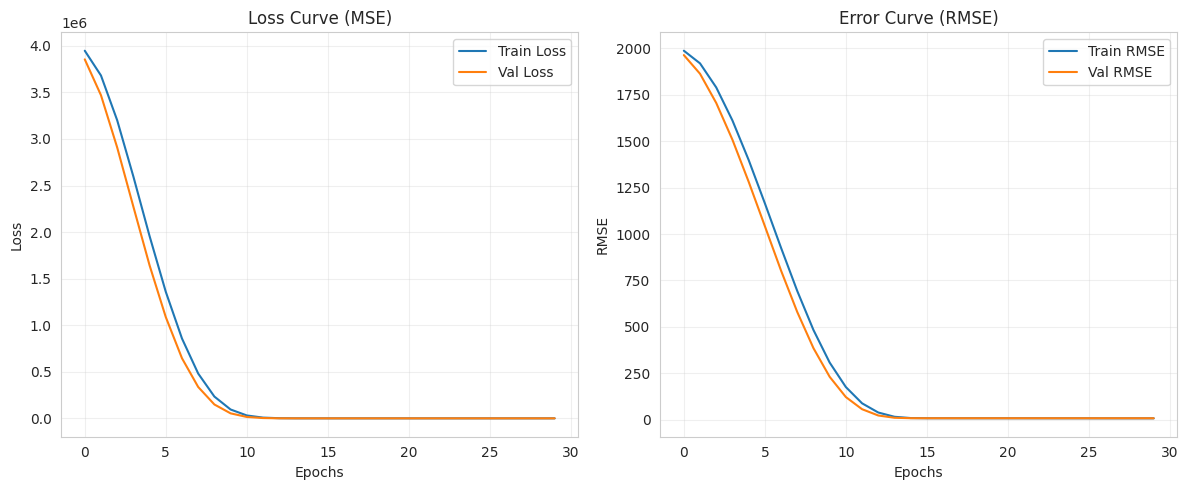

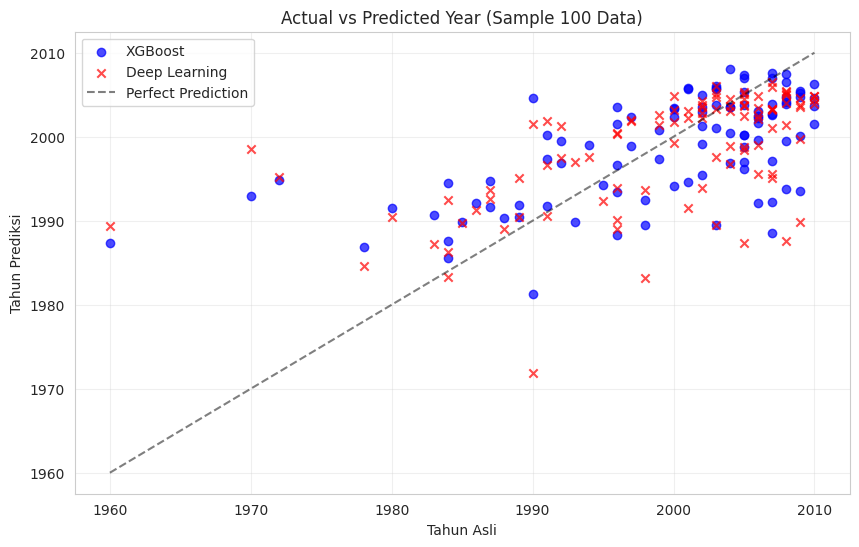

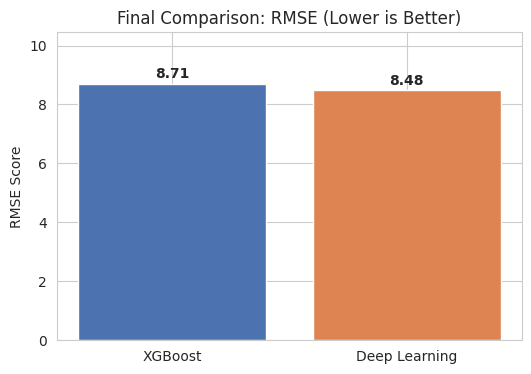


🏆 KESIMPULAN: Model Terbaik adalah Deep Learning dengan selisih RMSE 0.2261


In [38]:
def get_metrics(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)  # Hitung akar kuadrat manual agar tidak error
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"--- {name} ---")
    print(f"RMSE : {rmse:.4f} (Rata-rata meleset {rmse:.1f} tahun)")
    print(f"MAE  : {mae:.4f}")
    print(f"R²   : {r2:.4f}\n")
    return rmse

print("=== HASIL EVALUASI AKHIR ===")
# Hitung ulang metrik untuk perbandingan
rmse_xgb = get_metrics(y_test, y_pred_xgb, "XGBoost")
rmse_dl = get_metrics(y_test, y_pred_dl, "Deep Learning")

# 2. Plot Learning Curve (Khusus Deep Learning)
# Memastikan object 'history' ada (dari training Neural Network sebelumnya)
if 'history' in globals():
    plt.figure(figsize=(12, 5))

    # Plot Loss (MSE)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Curve (MSE)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot RMSE (Metrics)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['rmse'], label='Train RMSE')
    plt.plot(history.history['val_rmse'], label='Val RMSE')
    plt.title('Error Curve (RMSE)')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Objek 'history' tidak ditemukan. Pastikan cell training Neural Network sudah dijalankan.")

# 3. Plot Actual vs Predicted (Sample 100 titik)
# Kita ambil sampel acak agar plot tidak terlalu padat
np.random.seed(42)
indices = np.random.choice(len(y_test), 100, replace=False)

y_real_sample = y_test.iloc[indices]
y_xgb_sample = y_pred_xgb[indices]
y_dl_sample = y_pred_dl[indices]

plt.figure(figsize=(10, 6))
plt.scatter(y_real_sample, y_xgb_sample, alpha=0.7, label='XGBoost', marker='o', color='blue')
plt.scatter(y_real_sample, y_dl_sample, alpha=0.7, label='Deep Learning', marker='x', color='red')

# Garis Ideal (Perfect Fit)
min_val = min(y_real_sample.min(), y_xgb_sample.min())
max_val = max(y_real_sample.max(), y_xgb_sample.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Perfect Prediction')

plt.title('Actual vs Predicted Year (Sample 100 Data)')
plt.xlabel('Tahun Asli')
plt.ylabel('Tahun Prediksi')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 4. Bar Chart Perbandingan RMSE
plt.figure(figsize=(6, 4))
models = ['XGBoost', 'Deep Learning']
scores = [rmse_xgb, rmse_dl]
colors = ['#4c72b0', '#dd8452']

bars = plt.bar(models, scores, color=colors)
plt.ylim(0, max(scores) * 1.2)
plt.title('Final Comparison: RMSE (Lower is Better)')
plt.ylabel('RMSE Score')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., 1.01*height,
             f'{height:.2f}', ha='center', va='bottom', fontweight='bold')
plt.show()

# Kesimpulan Otomatis
winner = "XGBoost" if rmse_xgb < rmse_dl else "Deep Learning"
diff = abs(rmse_xgb - rmse_dl)
print(f"\n🏆 KESIMPULAN: Model Terbaik adalah {winner} dengan selisih RMSE {diff:.4f}")